Based on: https://www.kaggle.com/bbradt/loading-and-exploring-spatial-maps

In [2]:
#!pip install nilearn
#!pip install nibabel
# Download the ch2better template image for display
#!wget https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii

In [1]:
"""
    Load and display a subject's spatial map
"""

import numpy as np # linear algebra
from pathlib import Path
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
import h5py
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
import tqdm


for dirname, _, filenames in os.walk('/home/kaggle/TReNDS/input/fMRI_train'):
    #print(filenames)
    train_mat_names=filenames

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
mri_train_path = Path('/home/kaggle/TReNDS/input/fMRI_train')
kaggle_path = Path('/home/kaggle/TReNDS/') # '.'
kaggle_input_path = Path(kaggle_path/'input') # '/kaggle/input/trends-assessment-prediction'

mask_filename = '../input/fMRI_mask.nii' #kaggle_input_path/
subject_filename = mri_train_path/'10004.mat'
smri_filename = 'ch2better.nii'

print(mask_filename)

mask_niimg = nl.image.load_img(mask_filename)

def load_subject(filename, mask_niimg):
    """
    Load a subject saved in .mat format with
        the version 7.3 flag. Return the subject
        niimg, using a mask niimg as a template
        for nifti headers.
        
    Args:
        filename    <str>            the .mat filename for the subject data
        mask_niimg  niimg object     the mask niimg object used for nifti headers
    """
    subject_data = None
    with h5py.File(filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    return subject_niimg


subject_niimg = load_subject(subject_filename, mask_niimg)
print("Image shape is %s" % (str(subject_niimg.shape)))
num_components = subject_niimg.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))


../input/fMRI_mask.nii
Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


/opt/conda/envs/fastai/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)
/opt/conda/envs/fastai/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


CPU times: user 11.7 s, sys: 359 ms, total: 12 s
Wall time: 12.1 s


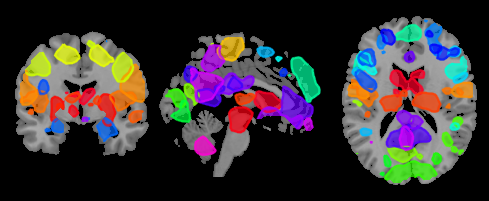

In [2]:
%%time
nlplt.plot_prob_atlas(subject_niimg, bg_img=smri_filename, view_type='filled_contours', annotate=False, draw_cross=False, threshold='auto')

In [3]:

def convert_to_png(filename):
    try:
        subject_filename = mri_train_path/filename
        subject_niimg = load_subject(subject_filename, mask_niimg)
        nlplt.plot_prob_atlas(subject_niimg, bg_img=smri_filename, 
                              view_type='filled_contours', annotate=False, 
                              draw_cross=False, threshold='auto', 
                              alpha = 0.6, output_file='../input/train_png/'+filename.split('.')[0]+'.png')
    except:
        pass

In [ ]:
convert_to_png('10002.mat')

In [4]:
pix=[]
for dirname, _, filenames in os.walk('/home/kaggle/TReNDS/input/train_png/'):
    pix=pix+filenames
    #print(filenames)

pngs = []
for p in pix:
    #print(p.split('.')[0]+'.mat')
    pngs = pngs+[p.split('.')[0]+'.mat']

len(pngs)

5833

In [5]:
train_mat_names= list(set(train_mat_names)-set(pngs))
len(train_mat_names)

50

In [6]:
%%time

pool = mp.Pool(mp.cpu_count())

tasks = [filename for filename in sorted(train_mat_names)]
for _ in tqdm.tqdm(pool.imap(convert_to_png, tasks), total=len(tasks)): #_unordered
    pass

#pool.map(convert_to_png, [filename for filename in sorted(train_mat_names)[4:100]])

pool.close()


100%|██████████| 50/50 [06:19<00:00,  7.59s/it]

CPU times: user 270 ms, sys: 104 ms, total: 374 ms
Wall time: 6min 19s
